In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

### Create generator and discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [10]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [11]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [12]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [13]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

C:\Users\vkrin\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch:1 Iter: 100 errD_x: 0.24 errD_z: 0.09 errG: 2.56
Epoch:1 Iter: 200 errD_x: 0.11 errD_z: 0.08 errG: 2.82
Epoch:1 Iter: 300 errD_x: 0.17 errD_z: 0.08 errG: 2.80
Epoch:1 Iter: 400 errD_x: 0.57 errD_z: 0.09 errG: 2.61
Epoch:1 Iter: 500 errD_x: 0.18 errD_z: 0.09 errG: 2.63
Epoch:1 Iter: 600 errD_x: 0.07 errD_z: 0.04 errG: 3.27
Epoch:1 Iter: 700 errD_x: 0.01 errD_z: 0.07 errG: 2.95
Epoch:1 Iter: 800 errD_x: 0.06 errD_z: 0.06 errG: 3.12
Epoch:1 Iter: 900 errD_x: 0.36 errD_z: 0.09 errG: 2.44
Epoch:1 Iter: 1000 errD_x: 0.37 errD_z: 0.22 errG: 1.78
Epoch:1 Iter: 1100 errD_x: 0.30 errD_z: 0.14 errG: 2.26
Epoch:1 Iter: 1200 errD_x: 0.05 errD_z: 0.19 errG: 2.15
Epoch:1 Iter: 1300 errD_x: 0.23 errD_z: 0.28 errG: 1.83
Epoch:1 Iter: 1400 errD_x: 0.22 errD_z: 0.28 errG: 1.80
Epoch:1 Iter: 1500 errD_x: 0.11 errD_z: 0.22 errG: 2.13
Epoch:1 Iter: 1600 errD_x: 0.13 errD_z: 0.12 errG: 2.72
Epoch:1 Iter: 1700 errD_x: 0.12 errD_z: 0.23 errG: 2.19
Epoch:1 Iter: 1800 errD_x: 0.29 errD_z: 0.11 errG: 2.64
E

Epoch:4 Iter: 3600 errD_x: 0.31 errD_z: 0.17 errG: 2.50
Epoch:4 Iter: 3700 errD_x: 0.21 errD_z: 0.16 errG: 2.14
Epoch:5 Iter: 100 errD_x: 0.38 errD_z: 0.11 errG: 3.22
Epoch:5 Iter: 200 errD_x: 0.52 errD_z: 0.18 errG: 2.12
Epoch:5 Iter: 300 errD_x: 0.43 errD_z: 0.13 errG: 3.13
Epoch:5 Iter: 400 errD_x: 0.27 errD_z: 0.59 errG: 1.51
Epoch:5 Iter: 500 errD_x: 0.39 errD_z: 0.16 errG: 2.78
Epoch:5 Iter: 600 errD_x: 0.52 errD_z: 0.47 errG: 1.62
Epoch:5 Iter: 700 errD_x: 0.32 errD_z: 0.15 errG: 1.95
Epoch:5 Iter: 800 errD_x: 0.56 errD_z: 0.10 errG: 2.80
Epoch:5 Iter: 900 errD_x: 0.15 errD_z: 0.28 errG: 2.64
Epoch:5 Iter: 1000 errD_x: 0.16 errD_z: 0.18 errG: 2.28
Epoch:5 Iter: 1100 errD_x: 0.63 errD_z: 0.13 errG: 2.58
Epoch:5 Iter: 1200 errD_x: 0.11 errD_z: 0.25 errG: 2.11
Epoch:5 Iter: 1300 errD_x: 0.39 errD_z: 0.10 errG: 2.73
Epoch:5 Iter: 1400 errD_x: 0.40 errD_z: 0.12 errG: 2.40
Epoch:5 Iter: 1500 errD_x: 0.49 errD_z: 0.13 errG: 2.95
Epoch:5 Iter: 1600 errD_x: 0.05 errD_z: 0.15 errG: 3.40
E

Epoch:8 Iter: 3400 errD_x: 0.46 errD_z: 0.22 errG: 2.74
Epoch:8 Iter: 3500 errD_x: 0.63 errD_z: 0.06 errG: 3.71
Epoch:8 Iter: 3600 errD_x: 0.13 errD_z: 0.61 errG: 1.14
Epoch:8 Iter: 3700 errD_x: 0.76 errD_z: 0.23 errG: 2.01
Epoch:9 Iter: 100 errD_x: 0.25 errD_z: 0.38 errG: 1.73
Epoch:9 Iter: 200 errD_x: 0.31 errD_z: 0.11 errG: 2.57
Epoch:9 Iter: 300 errD_x: 0.34 errD_z: 0.27 errG: 2.11
Epoch:9 Iter: 400 errD_x: 0.57 errD_z: 0.15 errG: 2.56
Epoch:9 Iter: 500 errD_x: 0.52 errD_z: 0.11 errG: 2.98
Epoch:9 Iter: 600 errD_x: 0.31 errD_z: 0.12 errG: 2.32
Epoch:9 Iter: 700 errD_x: 0.17 errD_z: 0.21 errG: 1.94
Epoch:9 Iter: 800 errD_x: 0.51 errD_z: 0.29 errG: 2.98
Epoch:9 Iter: 900 errD_x: 0.49 errD_z: 0.11 errG: 2.28
Epoch:9 Iter: 1000 errD_x: 0.31 errD_z: 0.34 errG: 1.73
Epoch:9 Iter: 1100 errD_x: 0.88 errD_z: 0.08 errG: 3.37
Epoch:9 Iter: 1200 errD_x: 0.18 errD_z: 0.35 errG: 1.42
Epoch:9 Iter: 1300 errD_x: 0.39 errD_z: 0.35 errG: 1.75
Epoch:9 Iter: 1400 errD_x: 0.50 errD_z: 0.69 errG: 0.86
E

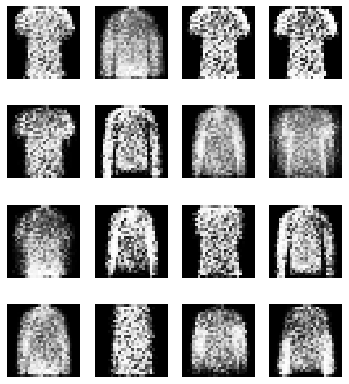

In [14]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')